This notebook takes ~10 seconds to run.

There are interactive scatter plots and search function (also online) for you to play with. 

Have fun.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

with open("./../models/final_model.pkl", "rb") as f:
    data = pickle.load(f)
model = data["model"]

with open("./../models/StandardScalers.pkl", "rb") as f:
    data = pickle.load(f)
SS_y = data["SS_y"]

df = pd.read_parquet("./../data/steam_game_dataset.parquet")
df_conf_tier = pd.read_parquet('./../data/df_conf_tier_v1.parquet')
df_X_z = pd.read_parquet('./../data/df_X_z_v1.parquet')

all_X = df_X_z.to_numpy(dtype="float32")
y_pred = SS_y.inverse_transform(model.predict(all_X).reshape(-1, 1)).squeeze(-1)

conf_map = {1: "low", 2: "medium", 3: "high", 4: "very high"}

df_results = pd.DataFrame({
    "app_id": df['AppID'],
    "name": df['Name'],
    "metacritic_score": df['Metacritic score'].astype(float),
    "pred_score": y_pred,
    "conf_tier": df_conf_tier['tier_label'],
    "conf_label": df_conf_tier['tier_label'].replace(conf_map)}
    ).sort_values(["conf_tier","metacritic_score","pred_score"],ascending=[False,False,False])



# Show results

## Let's see if we can find hidden gems!

### Games with no Metacritic score, but has a high predicted score with high confidence, are printed in the table below, ordered by predicted score (going across).


In [2]:
import math

mask = (df_results["conf_tier"]==4) & (df_results["metacritic_score"]<=0)
# build the per-row cell text
cells = [
    f"{t}<br>{s:.1f}"
    for t, s in zip(df_results.loc[mask,"name"], 
                       df_results.loc[mask,"pred_score"])
]

n_cols = 4
n_rows = math.ceil(len(cells) / n_cols)

# pad to fill the last row if needed
cells += [""] * (n_rows * n_cols - len(cells))

table = pd.DataFrame(
    np.array(cells).reshape(n_rows, n_cols)
)
display(
    table.style.set_properties(**{"white-space": "pre-line"})
)

print(table.to_string(index_names=False, header=False))

0     Total War: MEDIEVAL II – Definitive Edition<br>87.3               STAR WARS™ - Knights of the Old Republic™<br>86.6                                   FINAL FANTASY VII<br>85.9                                                          Half-Life: Opposing Force<br>85.6
1            STAR WARS™ Empire at War - Gold Pack<br>85.6             Warhammer® 40,000: Dawn of War® - Soulstorm<br>85.1                   Halo: The Master Chief Collection<br>85.0                                                      Commandos: Behind Enemy Lines<br>84.8
2                Marvel's Guardians of the Galaxy<br>84.7                                          Sea of Thieves<br>84.7                           Assassin's Creed® Origins<br>84.6                                                          Assassin's Creed® Odyssey<br>84.6
3                                    Superliminal<br>84.4                                           Ultimate Doom<br>84.3                       Hotline Miami 2: Wrong Number<br>84.3

# Visualization

## In the interactive scatter plots below, you can check out predicted scores of games with (cloud on the right) and without (cloud on the left) a Metacritic score.

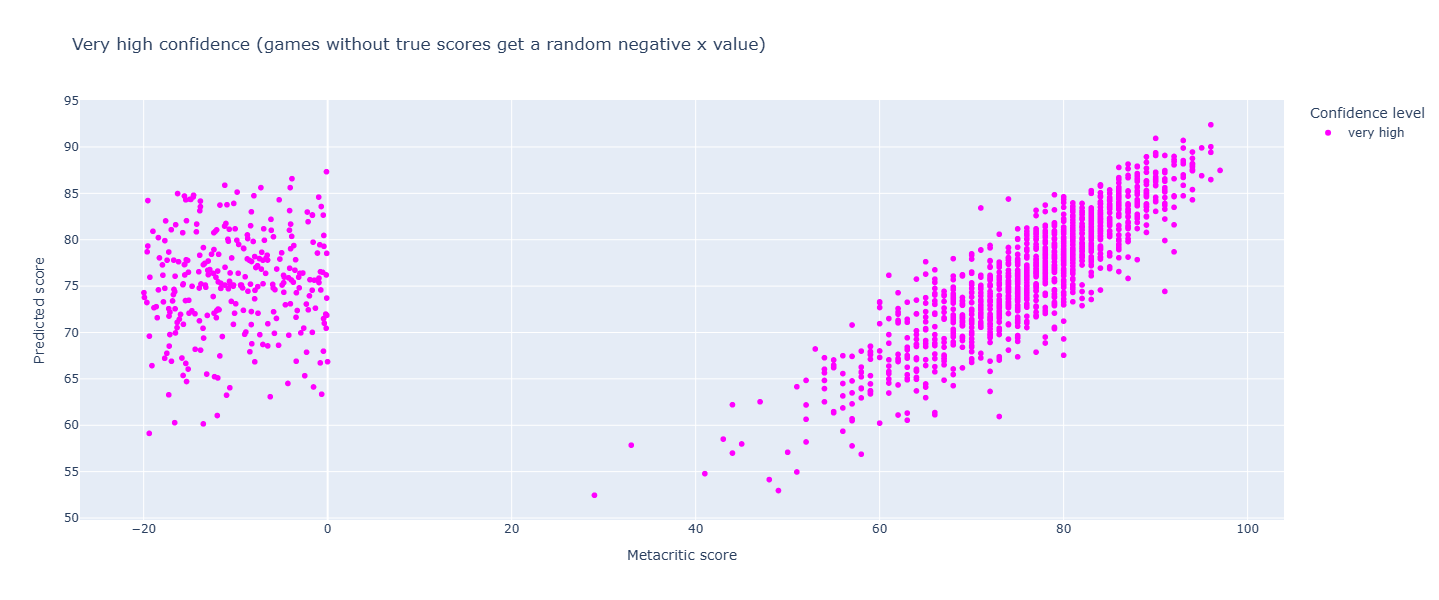

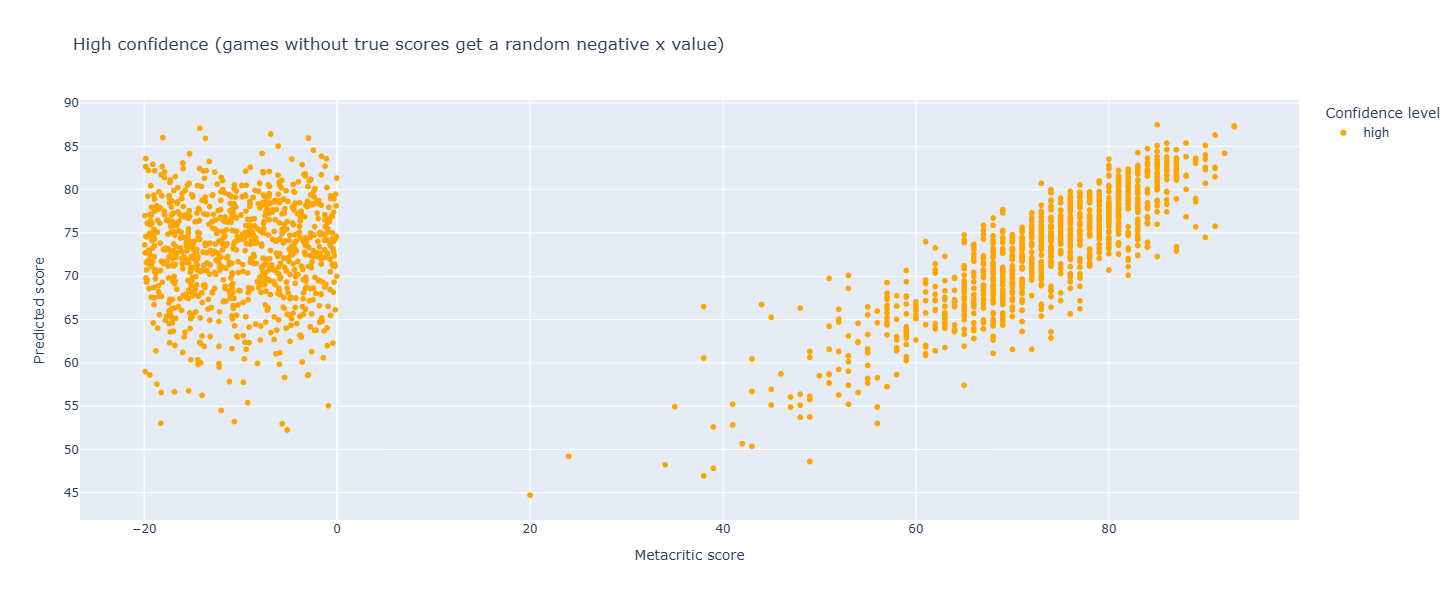

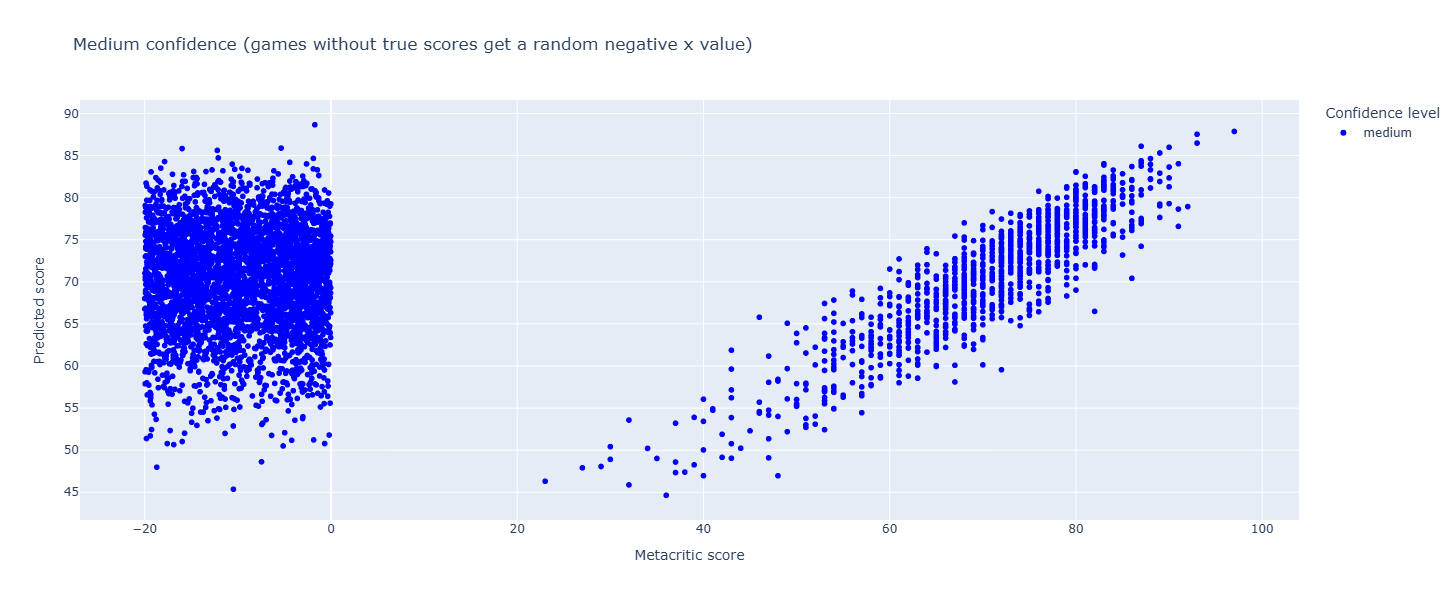

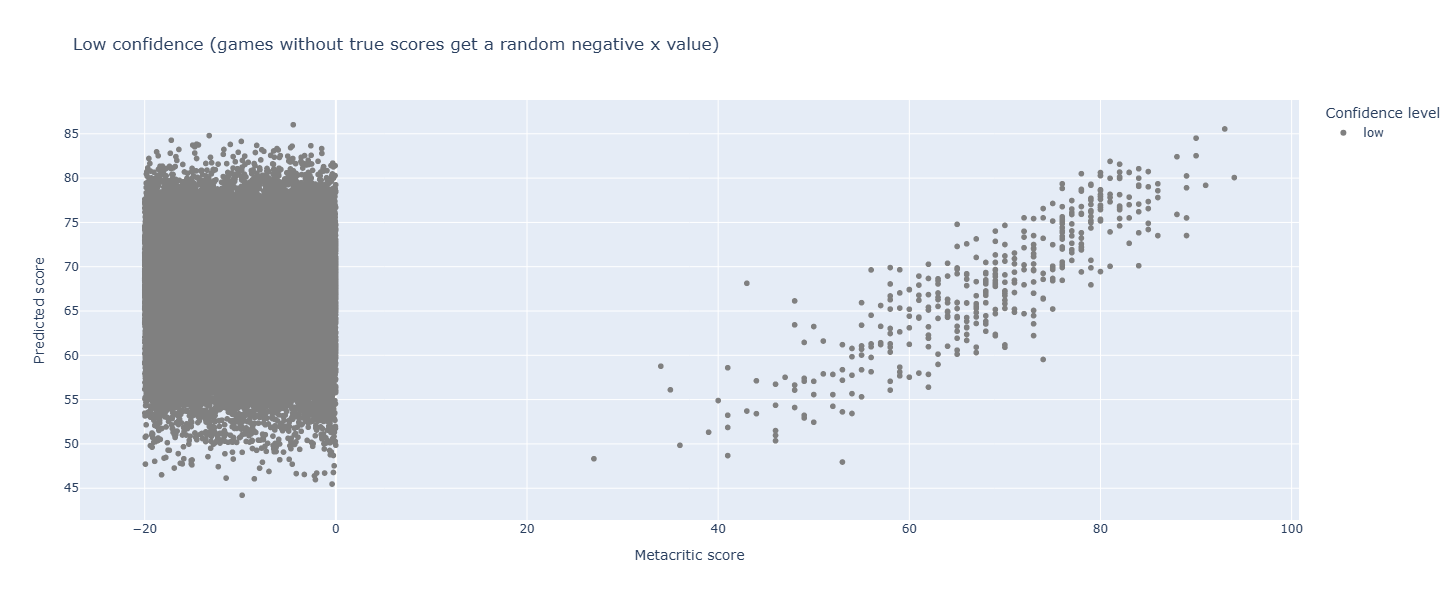

In [9]:
import plotly.express as px

def plot_px_scatter(ct,cname,t):
    df = df_results.copy()
    mask = df["metacritic_score"] == 0
    df.loc[mask, "metacritic_score"] += np.random.uniform(-20, 0, size=mask.sum())
    fig = px.scatter(
        df.loc[df["conf_tier"]==ct],
        x="metacritic_score",
        y="pred_score",
        color="conf_label",
        color_discrete_sequence=[cname],
        hover_data=["name","app_id"],
        labels={"metacritic_score": "Metacritic score",
                "pred_score": "Predicted score",
                "conf_label": "Confidence level",
                "name": "Game title"},
        title=(t+"\n(games without true scores get a random negative x value)"),
        width=800, height=600)
    fig.show()
    # fig.write_html(f"./../interactives/{t.lower().replace(' ', '_')}.html")
    

plot_px_scatter(4,"magenta","Very high confidence")
plot_px_scatter(3,"orange","High confidence")
plot_px_scatter(2,"blue","Medium confidence")
plot_px_scatter(1,"gray","Low confidence")


# Search games

## Scroll down to the bottom to search for games in the dataframe.

In [4]:
import re

def search_rows(df,col,q,
    fuzzy_threshold=80,fuzzy_topk=50):
    
    s = df[col].astype("string")

    if q is None or str(q).strip() == "":
        return df.iloc[0:0]  # empty result

    from rapidfuzz import process, fuzz

    choices = s.fillna("").tolist()
    hits = process.extract(q, choices, scorer=fuzz.WRatio, limit=fuzzy_topk)
    keep = [(match, score, idx) for (match, score, idx) in hits if score >= fuzzy_threshold]
    if not keep:
        return df.iloc[0:0]
    idxs = [k[2] for k in keep]
    scores = [k[1] for k in keep]
    # return df.iloc[idxs].assign(_fuzzy_score=scores)
    return df.iloc[idxs]


In [5]:
# put your search keyword here
searchname = "punk"


matches = search_rows(df_results, "name", searchname,fuzzy_threshold=78)

pd.options.display.float_format = "{:.1f}".format
matches

app_id                             name  metacritic_score  pred_score  \
8009   1091500                   Cyberpunk 2077              86.0        86.1   
57399   323190                        Frostpunk              84.0        82.7   
9869    250260         Jazzpunk: Director's Cut              75.0        74.6   
23450   746850                        Cloudpunk              73.0        75.9   
30100   878420                         Woodpunk               0.0        67.6   
553     622460                Steampunk Tower 2               0.0        63.7   
72552  1183800            Shardpunk: Verminfall               0.0        81.0   
8692    540190                        Tetropunk               0.0        77.1   
41449  1361680                  cyberpunkdreams               0.0        76.6   
69004  1863290       SpunkStock: Music Festival               0.0        76.2   
73974  1596730                         Dynopunk               0.0        75.0   
68566  2256670               Gnomepunk Playtest               0.0        74.2   
61414  1500490                        Teslapunk               0.0        72.5   
74516  2437910                   Reformpunk重組叛客               0.0        72.1   
40005   956430              Steampunk Graveyard               0.0        71.3   
70398  2198570                          Neopunk               0.0        71.2   
44768  1207310      Gizmos: Steampunk Nonograms               0.0        71.0   
10938   757430                      Schwerpunkt               0.0        70.7   
67938  2235800                    Futapunk 2069               0.0        70.4   
78675  2477140   Twilight Town: A Cyberpunk FPS               0.0        70.2   
42142   550990    Viktor, a Steampunk Adventure               0.0        70.2   
40036  1793840      Gamer Girls: Cyberpunk 2069               0.0        70.0   
79349  2593710    Cyberpunk: Red-Light District               0.0        69.9   
50051  1590250                  Junkpunk: Arena               0.0        69.8   
26141  1633410                 Cyborpunk Crisis               0.0        69.4   
62567  1925330                        cyVeRpunk               0.0        68.8   
53456  1589370                        Speedpunk               0.0        68.8   
14425  1506640                        Hatchpunk               0.0        68.7   
82149  2561360         Steampunk Jigsaw Puzzles               0.0        68.6   
3716   1372090                 Hentai Cyberpunk               0.0        68.6   
4200   1867280                  Cyberpunk Girls               0.0        68.0   
11956   803850                     Pixelpunk XL               0.0        68.0   
66361  2205950                        Witchpunk               0.0        68.0   
64353  2150370       Running into the Cyberpunk               0.0        67.8   
54634  1465260                    Cyberpunk SFX               0.0        67.6   
71706  2340990              Jump Jump Cyberpunk               0.0        67.5   
30597   742470          Chronicles of cyberpunk               0.0        67.3   
21507  1700250            Cypherpunk Essentials               0.0        67.3   
51753  1606270        Pleasurepunk: Drug Dealer               0.0        67.1   
14189  1252170    InfiniteCorp: Cyberpunk Cards               0.0        67.0   
80370  2364720          Cy: Cyberpunk Survivors               0.0        67.0   
37835  1175950          Cyberpunk Sex Simulator               0.0        66.9   
74538  2340160            Sexy Cyberpunk Puzzle               0.0        66.8   
35396  1134180    Cyberpunk hentai: Memory leak               0.0        66.5   
34297  1014270               Plaguepunk Justice               0.0        66.3   
13531  1797840               Cyberpunk Fighting               0.0        66.2   
12133  1554380                Cyberpunk Madness               0.0        66.2   
29105  1488080   Hentai Nureta Puzzle Cyberpunk               0.0        66.2   
72200  2321460  Dynopunk: Welcome to Sy